<a href="https://colab.research.google.com/github/vd4mmind/sgRNA_library/blob/main/sgRNA_Ryvu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**sgRNA library characterization**


1.   Perform mapping of sgRNA sequences (provided multifasta file: library.fa) to GRCh38.
2.   For each of the mapped sgRNA sequence provide the following information: chromosome name, start and end positions, strand.
3. Assign gene names based on mapping results and compare obtained annotation with gene names provided within description lines of fasta file.
4. Retrieve matrix of gene expression for the gene IDs from previous step for sample "TCGA-A7-A13D-01A-13R-A12P-07" and "TCGA-E9-A1RH-11A-34R-A169-07" from TCGA-BRCA dataset.

Please wrap your solution in a simple pipeline (use which ever technology you feel suits best for it); use docker for virtualization of used software and provide short documentation.
As an outcome, please provide the link to the git with code, documentation and results.

The entire code should be reproducible in Google Colab as along as required packages are installed properly in both Python and R environment.

This notebook is solely executed via Google Colab using the Google Drive as the storage space.

The package installation snippets are commented out for now.

# Mount the directory and identify the folder
Here we are using the google drive with larger volume (Personal drive)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# List before after changing directory
!ls
%cd /content/drive/MyDrive/Ryvu
!ls

drive  sample_data
/content/drive/MyDrive/Ryvu
6b62d6dd-bb6f-4f39-9041-992c47b875f3.txt  hg38_index.rev.2.bt2
Bioinfo_task_description_TL.docx	  Homo_sapiens.GRCh38.104.gtf
GDCdata					  knownGene.txt
gene_annotation.bed			  knownGene.txt.gz.1
hg38.fa					  library.fa
hg38.fa.fai				  MANIFEST.txt
hg38.fa.gz				  mapped_sequences.bam
hg38_index.1.bt2			  mapped_sequences.sam
hg38_index.2.bt2			  sorted_sequences.bam
hg38_index.3.bt2			  sorted_sequences.bam.bai
hg38_index.4.bt2			  test
hg38_index.rev.1.bt2


# Down the required files and install the required libraries Part I

In [3]:
#!apt-get install -y bowtie2 samtools
#!pip install biopython pyensembl pysam


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libhts3 libhtscodecs2
Suggested packages:
  bowtie2-examples cwltool
The following NEW packages will be installed:
  bowtie2 libhts3 libhtscodecs2 samtools
0 upgraded, 4 newly installed, 0 to remove and 16 not upgraded.
Need to get 2,131 kB of archives.
After this operation, 6,005 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhtscodecs2 amd64 1.1.1-3 [53.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhts3 amd64 1.13+ds-2build1 [390 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 samtools amd64 1.13-4 [520 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 bowtie2 amd64 2.4.4-1 [1,169 kB]
Fetched 2,131 kB in 0s (5,181 kB/s)
Selecting previously unselected package libhtscodecs2:amd64.
(Reading database ... 120831 files and directo

# Create Required alignment file using bowtie 2 from the provided fasta file

In [ ]:
# Map sgRNA sequences using Bowtie2
!bowtie2 -x hg38_index -f -U library.fa -S mapped_sequences.sam

77736 reads; of these:
  77736 (100.00%) were unpaired; of these:
    484 (0.62%) aligned 0 times
    51410 (66.13%) aligned exactly 1 time
    25842 (33.24%) aligned >1 times
99.38% overall alignment rate


# Convert the sam alignment file to bam, followed by sorting and indexing

In [ ]:
# Extracting mapping information via converting to bam and sort it
!samtools view -b mapped_sequences.sam > mapped_sequences.bam
!samtools sort mapped_sequences.bam -o sorted_sequences.bam
!samtools index sorted_sequences.bam


# Download the Ensmeble Release for downstream tasks

In [ ]:
# Download the gene annotation for GRCh38
from pyensembl import EnsemblRelease

# This will download the necessary data files if they haven't been downloaded yet
data = EnsemblRelease(95)
data.download()
data.index()


In [9]:
#!pip install numpy

# # This section parses the GTF file and the sorted BAM file extract the gene list

In [10]:
import pysam

# Step 1: Parse the GTF file
def parse_gtf(gtf_file):
    gene_data = {}
    with open(gtf_file, 'r') as f:
        for line in f:
            if not line.startswith('#'):  # skip header lines
                fields = line.strip().split('\t')
                if fields[2] == 'gene':
                    chrom = fields[0]
                    start = int(fields[3])
                    end = int(fields[4])
                    # Extract gene name from the attributes column
                    for attribute in fields[8].split('; '):
                        if attribute.startswith('gene_name'):
                            gene_name = attribute.split(' ')[1].replace('"', '')
                            break
                    gene_data.setdefault(chrom, []).append((start, end, gene_name))
    return gene_data

gene_data = parse_gtf("Homo_sapiens.GRCh38.104.gtf")

# Step 2 & 3: Loop over BAM file and annotate
bamfile = pysam.AlignmentFile("sorted_sequences.bam", "rb")
unique_genes = set()

for read in bamfile:
    chrom = read.reference_name
    if chrom is None:
        continue  # skip this read if chrom is None

    # Handle chromosome naming discrepancy between GTF and BAM
    if chrom not in gene_data:
        if chrom.startswith('chr'):
            chrom = chrom[3:]
        else:
            chrom = 'chr' + chrom
    start = read.reference_start
    end = read.reference_end
    if chrom in gene_data:
        for gene_start, gene_end, gene_name in gene_data[chrom]:
            if start <= gene_end and end >= gene_start:  # Overlap check
                unique_genes.add(gene_name)
bamfile.close()

# Convert the set to a list
unique_gene_list = list(unique_genes)
print(unique_gene_list)


['CDC14B', 'USF3', 'NAE1', 'STX19', 'EEF1A1P16', 'ANKRD42', 'SNRPD3', 'PNMA6B', 'IGHV3-64D', 'HPF1', 'DNAJC19P9', 'ARPC2', 'DHRS7', 'HSD17B7', 'NPAS3', 'GSTZ1', 'MLN', 'SLC27A6', 'AIDAP1', 'PTHLH', 'TTC39A', 'NSD2', 'ZFP1', 'ENHO', 'STK4', 'LSM14B', 'HIVEP3', 'CFAP69', 'C1orf109', 'ADAMTS18', 'COX8C', 'TCN1', 'MIS18A', 'TGFBR3', 'SCGB3A1', 'CATSPER2', 'POLR1E', 'OR5H14', 'USP7', 'SULT1A4', 'AP2S1', 'EIF4A1P7', 'EYS', 'RBM41', 'SHISA4', 'LMBRD1', 'DSC1', 'RCAN3', 'ZNF705E', 'ADORA2B', 'KCTD7', 'THADA', 'VWA2', 'MDGA1', 'SLC46A1', 'DCAF6', 'BEX3', 'DDX3P3', 'AQR', 'TMOD4', 'UGT2B25P', 'NMD3P1', 'CCNY', 'SLC30A6', 'CFAP206', 'THEGL', 'WSCD2', 'CDC25B', 'NTNG2', 'PIP', 'COG8', 'ENTHD1', 'TSLP', 'ZPLD1', 'KCNH1', 'KLRG2', 'POTEC', 'GUCA1ANB', 'PSMB5', 'B4GALT4-AS1', 'TDRD12', 'C19orf54', 'STAT5A', 'FLRT1', 'BICDL1', 'SPPL2B', 'LYZL4', 'RHEBP1', 'PRPF40A', 'PCDHGA9', 'LINC00861', 'ATPSCKMT', 'RHOJ', 'RALGAPB', 'GATA3', 'ECM1', 'CDK8', 'INTS6', 'ZDHHC22', 'DNAH12', 'GDPD1', 'CHCHD2', 'DMRTB1'

In [11]:
unique_gene_list

['CDC14B',
 'USF3',
 'NAE1',
 'STX19',
 'EEF1A1P16',
 'ANKRD42',
 'SNRPD3',
 'PNMA6B',
 'IGHV3-64D',
 'HPF1',
 'DNAJC19P9',
 'ARPC2',
 'DHRS7',
 'HSD17B7',
 'NPAS3',
 'GSTZ1',
 'MLN',
 'SLC27A6',
 'AIDAP1',
 'PTHLH',
 'TTC39A',
 'NSD2',
 'ZFP1',
 'ENHO',
 'STK4',
 'LSM14B',
 'HIVEP3',
 'CFAP69',
 'C1orf109',
 'ADAMTS18',
 'COX8C',
 'TCN1',
 'MIS18A',
 'TGFBR3',
 'SCGB3A1',
 'CATSPER2',
 'POLR1E',
 'OR5H14',
 'USP7',
 'SULT1A4',
 'AP2S1',
 'EIF4A1P7',
 'EYS',
 'RBM41',
 'SHISA4',
 'LMBRD1',
 'DSC1',
 'RCAN3',
 'ZNF705E',
 'ADORA2B',
 'KCTD7',
 'THADA',
 'VWA2',
 'MDGA1',
 'SLC46A1',
 'DCAF6',
 'BEX3',
 'DDX3P3',
 'AQR',
 'TMOD4',
 'UGT2B25P',
 'NMD3P1',
 'CCNY',
 'SLC30A6',
 'CFAP206',
 'THEGL',
 'WSCD2',
 'CDC25B',
 'NTNG2',
 'PIP',
 'COG8',
 'ENTHD1',
 'TSLP',
 'ZPLD1',
 'KCNH1',
 'KLRG2',
 'POTEC',
 'GUCA1ANB',
 'PSMB5',
 'B4GALT4-AS1',
 'TDRD12',
 'C19orf54',
 'STAT5A',
 'FLRT1',
 'BICDL1',
 'SPPL2B',
 'LYZL4',
 'RHEBP1',
 'PRPF40A',
 'PCDHGA9',
 'LINC00861',
 'ATPSCKMT',
 'RHOJ',
 

In [12]:
#!pip install matplotlib-venn


# Match the extracted gene list from the BAM, overlap it back with the genes in library.fa and create a matched gene list

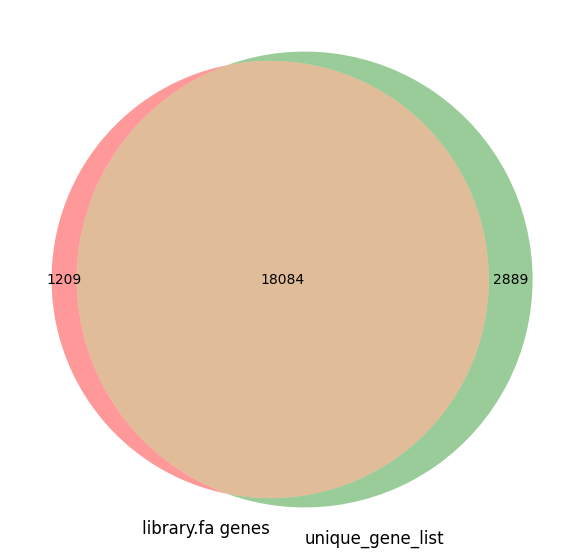

['ANKS1B', 'SPINK13', 'CDC14B', 'EVC', 'IL20RA', 'SRA1', 'LUC7L', 'C16orf97', 'ZNF592', 'ST3GAL2', 'LNP1', 'NAE1', 'STX19', 'AARS2', 'DBI', 'CCDC42', 'CCDC97', 'FHL1', 'FTH1', 'MAP3K7', 'SOX17', 'LSMEM1', 'CEACAM20', 'CDA', 'ANKRD42', 'RBM46', 'DCUN1D4', 'SNRPD3', 'TBC1D31', 'MYL3', 'CTBS', 'C2orf50', 'DUSP2', 'SLC25A33', 'EPHX3', 'NAV2', 'G6PC3', 'PRB4', 'ZNF197', 'RASSF9', 'LRRC8D', 'SLC43A2', 'MED22', 'MTX2', 'PTCRA', 'SPEM1', 'ARPC2', 'DHRS7', 'GTPBP10', 'DDX20', 'HSD17B7', 'NPAS3', 'L1TD1', 'TMEM176B', 'TMEM30B', 'COL9A1', 'GSTZ1', 'PRG2', 'MS4A5', 'NRSN1', 'TAPT1', 'MLN', 'SLC27A6', 'RABGAP1L', 'BIN2', 'TAOK3', 'PTHLH', 'HMGB4', 'CDH15', 'DNAH9', 'NR2F6', 'LIF', 'KCND3', 'ZDHHC24', 'TTC39A', 'LBH', 'GAL3ST3', 'PLEC', 'L3MBTL2', 'ARMCX4', 'IRAK1BP1', 'ACER3', 'KRTAP5-5', 'ENHO', 'LRRC74B', 'RBM5', 'CUL4A', 'TREX1', 'FREM2', 'HPR', 'GUCA1B', 'KBTBD7', 'MROH2B', 'ATP13A5', 'ETNPPL', 'KCTD3', 'LSM14B', 'MED26', 'SLC15A3', 'STK4', 'LZTS2', 'HIVEP3', 'KDM2B', 'MAP3K15', 'NSL1', 'LIPI',

In [13]:
import matplotlib.pyplot as plt
from Bio import SeqIO
from matplotlib_venn import venn2

# Extract unique gene names from library.fa
gene_names_from_fasta = set()

for record in SeqIO.parse("library.fa", "fasta"):
    desc = record.description.split("|")
    gene_name_from_desc = desc[-1]
    gene_names_from_fasta.add(gene_name_from_desc)

# Plotting the Venn diagram
plt.figure(figsize=(10, 7))
venn2([gene_names_from_fasta, set(unique_gene_list)], set_labels=['library.fa genes', 'unique_gene_list'])
plt.show()

# Convert the set to a list
gene_names_from_fasta_list = list(gene_names_from_fasta)

# Compare with unique_gene_list and store the matched gene list
matched_genes = list(set(gene_names_from_fasta_list) & set(unique_gene_list))

print(matched_genes)



# The following steps need R to be run from Google Colab to download the gene expression datasets from TCGA.

In [16]:
# Step 1: Set up R in Google Colab
%load_ext rpy2.ipython

In [17]:
#%%R

#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

#BiocManager::install("BioinformaticsFMRP/TCGAbiolinksGUI.data")
#BiocManager::install("BioinformaticsFMRP/TCGAbiolinks",force=TRUE)

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com



  Use `force = TRUE` to force installation

  'fontawesome', 'gargle', 'ggplot2', 'gtable', 'highr', 'httr', 'isoband',
  'openssl', 'rmarkdown', 'roxygen2', 'uuid', 'whisker', 'boot', 'foreign',
  'Matrix', 'nlme', 'survival'



Update all/some/none? [a/s/n]: n


'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com






These packages have more recent versions available.
It is recommended to update all of them.
Which would you like to update?

 1: All                            
 2: CRAN packages only             
 3: None                           
 4: bit     (4.0.4 -> 4.0.5) [CRAN]
 5: openssl (2.0.6 -> 2.1.0) [CRAN]
 6: curl    (5.0.0 -> 5.0.2) [CRAN]
 7: httr    (1.4.6 -> 1.4.7) [CRAN]
 8: isoband (0.2.6 -> 0.2.7) [CRAN]
 9: gtable  (0.3.3 -> 0.3.4) [CRAN]
10: highr   (0.9   -> 0.10 ) [CRAN]
11: ggplot2 (3.4.2 -> 3.4.3) [CRAN]

Enter one or more numbers, or an empty line to skip updates: 
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpwg71sy/remotes65814c0e0a0f/BioinformaticsFMRP-TCGAbiolinks-a4c3804/DESCRIPTION’ ... OK
* preparing ‘TCGAbiolinks’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘TCGAbiolink

  'fontawesome', 'gargle', 'ggplot2', 'gtable', 'highr', 'httr', 'isoband',
  'openssl', 'rmarkdown', 'roxygen2', 'uuid', 'whisker', 'boot', 'foreign',
  'Matrix', 'nlme', 'survival'



Update all/some/none? [a/s/n]: n


In [14]:
# In Python
matched_genes

['ANKS1B',
 'SPINK13',
 'CDC14B',
 'EVC',
 'IL20RA',
 'SRA1',
 'LUC7L',
 'C16orf97',
 'ZNF592',
 'ST3GAL2',
 'LNP1',
 'NAE1',
 'STX19',
 'AARS2',
 'DBI',
 'CCDC42',
 'CCDC97',
 'FHL1',
 'FTH1',
 'MAP3K7',
 'SOX17',
 'LSMEM1',
 'CEACAM20',
 'CDA',
 'ANKRD42',
 'RBM46',
 'DCUN1D4',
 'SNRPD3',
 'TBC1D31',
 'MYL3',
 'CTBS',
 'C2orf50',
 'DUSP2',
 'SLC25A33',
 'EPHX3',
 'NAV2',
 'G6PC3',
 'PRB4',
 'ZNF197',
 'RASSF9',
 'LRRC8D',
 'SLC43A2',
 'MED22',
 'MTX2',
 'PTCRA',
 'SPEM1',
 'ARPC2',
 'DHRS7',
 'GTPBP10',
 'DDX20',
 'HSD17B7',
 'NPAS3',
 'L1TD1',
 'TMEM176B',
 'TMEM30B',
 'COL9A1',
 'GSTZ1',
 'PRG2',
 'MS4A5',
 'NRSN1',
 'TAPT1',
 'MLN',
 'SLC27A6',
 'RABGAP1L',
 'BIN2',
 'TAOK3',
 'PTHLH',
 'HMGB4',
 'CDH15',
 'DNAH9',
 'NR2F6',
 'LIF',
 'KCND3',
 'ZDHHC24',
 'TTC39A',
 'LBH',
 'GAL3ST3',
 'PLEC',
 'L3MBTL2',
 'ARMCX4',
 'IRAK1BP1',
 'ACER3',
 'KRTAP5-5',
 'ENHO',
 'LRRC74B',
 'RBM5',
 'CUL4A',
 'TREX1',
 'FREM2',
 'HPR',
 'GUCA1B',
 'KBTBD7',
 'MROH2B',
 'ATP13A5',
 'ETNPPL',
 'KCTD3

In [18]:
#%%R
#devtools::install_github(repo = "grimbough/biomaRt",dependencies = T)

  Use `force = TRUE` to force installation



# load the relevant libraries to execute the tasks

In [19]:
%%R
library(TCGAbiolinks)
library(TCGAbiolinksGUI.data)

In [20]:
%%R
library(SummarizedExperiment)



Attaching package: ‘MatrixGenerics’



    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeightedMedians,
    rowWeightedSds, rowWeightedVars





Attachi

#  In this section, I am using the GDCquery function to build a query to retrieve the expression data for two samples from the project TCGA-BRCA, followed by preparing the relevant gene expression matrix, subsetting it with the matched genes from the previous tasks, and saving the matrix in CSV format

In [22]:
%%R
# Build a query for the TCGA-BRCA project
query <- GDCquery(project = 'TCGA-BRCA',
                  data.category = 'Transcriptome Profiling',
                  data.type = 'Gene Expression Quantification',
                  workflow.type = 'STAR - Counts',
                  access = 'open',
                  barcode = c("TCGA-A7-A13D-01A-13R-A12P-07", "TCGA-E9-A1RH-11A-34R-A169-07"))

getResults(query)

# Download the data
GDCdownload(query, method = "api")



Downloading: 2.1 MB     

In [23]:
%%R
# Prepare expression matrix with geneID in the rows and samples (barcode) in the columns
# Given the summarizedExperiment = FALSE, this will provide a large flat file
BRCA.Rnaseq.SE <- GDCprepare(query, summarizedExperiment = FALSE)
head(BRCA.Rnaseq.SE)
dim(BRCA.Rnaseq.SE)

|====================================================|100%                      Completed after 0 s 
[1] 60664    15


In [24]:
# Subset the relevant columns from the big flatfile of gene expression. I am selecting fpkm_uq_unstranded for this task
%%R
head(BRCA.Rnaseq.SE)
BRCA.Rnaseq.SE.flt <-BRCA.Rnaseq.SE[, c(1:3,14:15)]
head(BRCA.Rnaseq.SE.flt)
#dim(BRCA.Rnaseq.SE.flt)


              gene_id gene_name      gene_type
1: ENSG00000000003.15    TSPAN6 protein_coding
2:  ENSG00000000005.6      TNMD protein_coding
3: ENSG00000000419.13      DPM1 protein_coding
4: ENSG00000000457.14     SCYL3 protein_coding
5: ENSG00000000460.17  C1orf112 protein_coding
6: ENSG00000000938.13       FGR protein_coding
   fpkm_uq_unstranded_TCGA-A7-A13D-01A-13R-A12P-07
1:                                         13.1657
2:                                          0.0000
3:                                         46.1824
4:                                          1.6991
5:                                          3.5896
6:                                          1.3516
   fpkm_uq_unstranded_TCGA-E9-A1RH-11A-34R-A169-07
1:                                         16.2268
2:                                         10.7468
3:                                         27.4272
4:                                          3.1126
5:                                          0.7419
6:      

In [25]:
# converting the matched_genes list from python to R format
matched_genes

# Convert the Python list to a string format that R understands
r_vector = 'c("' + '", "'.join(matched_genes) + '")'

In [29]:
%%R -i r_vector

# Now,  have the variable in R
r_matched_genes <- eval(parse(text=r_vector))

# Check the transferred list in R
head(r_matched_genes)


[1] "ANKS1B"  "SPINK13" "CDC14B"  "EVC"     "IL20RA"  "SRA1"   


In [32]:
%%R

# Create the subsetted gene expression matrix

BRCA.Rnaseq.SE.flt.matched <- BRCA.Rnaseq.SE.flt[BRCA.Rnaseq.SE.flt$gene_name %in% r_matched_genes, ]

head(BRCA.Rnaseq.SE.flt.matched)

# Save the dataframe to a CSV file
write.csv(BRCA.Rnaseq.SE.flt.matched, "BRCA_Rnaseq_SE_flt_matched.csv", row.names=FALSE)

